# Choosing the best classifier for sign language dataset

In [26]:
import os
import pickle

import mediapipe as mp
import cv2

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

import warnings
warnings.filterwarnings('ignore')

In [9]:
data_dict = pickle.load(open('dataset_dictionary.pickle', 'rb'))

In [15]:
df = pd.DataFrame(data=data_dict['data'])
df['sign_number'] = data_dict['labels']
df.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,sign_number
0,0.265103,0.659515,-5.780071e-07,0.274388,0.529619,-0.014255,0.308740,0.427180,-0.032885,0.343098,...,0.465523,0.670108,-0.023550,0.444053,0.669272,-0.010747,0.418520,0.672938,-0.002720,0
1,0.267823,0.653711,-5.864543e-07,0.276522,0.525662,-0.013645,0.310798,0.424678,-0.031642,0.346129,...,0.463406,0.665492,-0.022687,0.443197,0.663287,-0.009959,0.418690,0.665825,-0.001716,0
2,0.260788,0.654245,-5.738153e-07,0.271176,0.524665,-0.014179,0.306902,0.423541,-0.032232,0.344289,...,0.461932,0.667372,-0.016328,0.440672,0.663517,-0.002312,0.415557,0.665270,0.006391,0
3,0.261010,0.650607,-5.862008e-07,0.270882,0.518189,-0.015732,0.307444,0.414518,-0.034513,0.344815,...,0.464078,0.666699,-0.020958,0.442737,0.662776,-0.007347,0.417485,0.665331,0.001566,0
4,0.261010,0.650607,-5.862008e-07,0.270882,0.518189,-0.015732,0.307444,0.414518,-0.034513,0.344815,...,0.464078,0.666699,-0.020958,0.442737,0.662776,-0.007347,0.417485,0.665331,0.001566,0


# The data we have

The data we have is coordinates which giving mediapipe based on my own photos of each sign


- **In the dataset there are such signs as:** *(starting from 0)*
    1. Like
    2. Like front
    3. Like inv
    4. Dislike
    5. Dislike front
    6. Dislike inv
    7. Ok
    8. Peace
    9. Peace inv
    10. Rock
    11. Rock inv
    12. YessPeace
    13. YessPeace inv

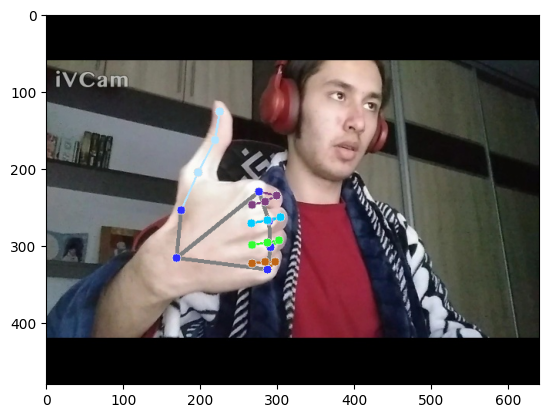

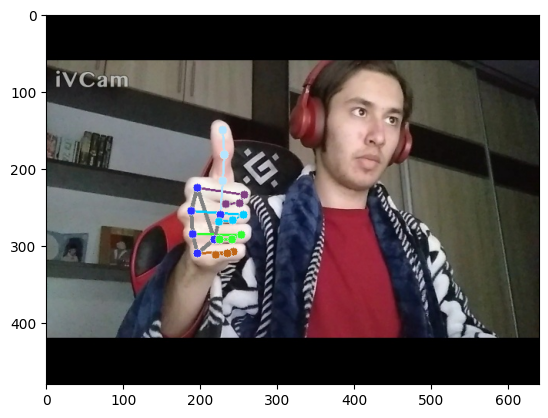

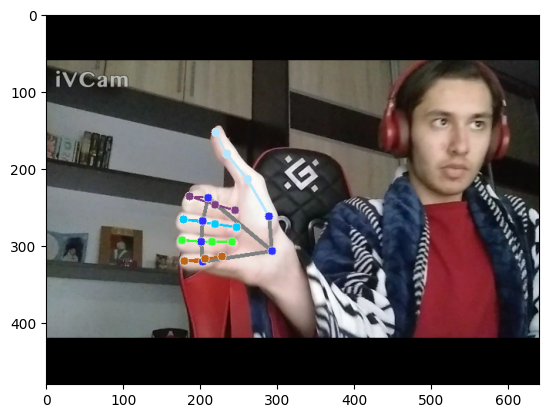

In [2]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

DATA_DIR = './data'

for dir_ in os.listdir(DATA_DIR):
    for img_path in os.listdir(os.path.join(DATA_DIR, dir_))[:1]:
        img = cv2.imread(os.path.join(DATA_DIR, dir_, img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        results = hands.process(img_rgb)

        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                img_rgb,  # image to draw
                hand_landmarks,  # model output
                mp_hands.HAND_CONNECTIONS,  # hand connections
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style(),
            )

        plt.figure()
        plt.imshow(img_rgb)

plt.show()

# Creating and training the model

In [20]:
inputs = df.drop(['sign_number'], axis=1)
target = df['sign_number']

In [21]:
inputs_scaled = StandardScaler().fit_transform(inputs)

In [22]:
model_params = {
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': (100, 150, 200)
        }
    },
    'Bagging': {
        'model': BaggingClassifier(max_samples=0.8, oob_score=True),
        'params': {
            'base_estimator': (DecisionTreeClassifier(), SVC(), LogisticRegression()),
            'n_estimators': (100, 150, 200)
        }
    },
}

In [27]:
scores = []

for model_name, mp in model_params.items():
    clf = RandomizedSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False, n_iter=20)

    clf.fit(inputs_scaled, target)  # training data

    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
df

,model,best_score,best_params
0,random_forest,1.0,{'n_estimators': 100}
1,Bagging,1.0,"{'n_estimators': 100, 'base_estimator': Decisi..."


# Training and saving the best model

The best model as you can see above is RandomForestClassifier or Bagging with DecisionTreeClassifier, which is the same thing

In [29]:
model = BaggingClassifier(max_samples=0.8, oob_score=True, n_estimators = 100, base_estimator = DecisionTreeClassifier())
model.fit(inputs_scaled, target)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=0.8,
                  n_estimators=100, oob_score=True)

In [30]:
with open('model.pickle', 'wb') as file:
    pickle.dump(model, file)